In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.metrics import accuracy_score

### Import Raw Data

In [2]:
app_event = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/app_events.csv")
app_label = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/app_labels.csv")
label_cat = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/label_categories.csv")
event = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/events.csv")
phone = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/phone_brand_device_model.csv")
gatrain = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/gender_age_train.csv")
gatest = pd.read_csv("C:/Users/Felix/Documents/data/TalkingData Kaggle/gender_age_test.csv")

In [3]:
# Quick look at the data
print ('----------------------------------------------------')
print ('app_event:')
print (app_event.head())
print ('----------------------------------------------------')
print ('app_label:')
print (app_label.head())
print ('----------------------------------------------------')
print ('label_cat:')
print (label_cat.head())
print ('----------------------------------------------------')
print ('event:')
print (event.head())
print ('----------------------------------------------------')
print ('phone:')
print (phone.head())
print ('----------------------------------------------------')
print ('gatrain:')
print (gatrain.head())
print ('----------------------------------------------------')


----------------------------------------------------
app_event:
   event_id               app_id  is_installed  is_active
0         2  5927333115845830913             1          1
1         2 -5720078949152207372             1          0
2         2 -1633887856876571208             1          0
3         2  -653184325010919369             1          1
4         2  8693964245073640147             1          1
----------------------------------------------------
app_label:
                app_id  label_id
0  7324884708820027918       251
1 -4494216993218550286       251
2  6058196446775239644       406
3  6058196446775239644       407
4  8694625920731541625       406
----------------------------------------------------
label_cat:
   label_id           category
0         1                NaN
1         2     game-game type
2         3   game-Game themes
3         4     game-Art Style
4         5  game-Leisure time
----------------------------------------------------
event:
   event_id     

In [4]:
# Check if all phones in "phone brand" table is in "gender train table"
# The result show the table "gatrain" is the subset of phone list
phone_list = phone.device_id.unique()
phone_in_gatrain = gatrain.device_id.unique()
phone_in_event = event.device_id.unique()
print (set(phone_list) > set(phone_in_gatrain))

True


In [5]:
# Merge "gatrain" with "phone" to get phone brand, model and age groups in the same table
gatrain = gatrain.drop_duplicates()
phone = phone.drop_duplicates()
df = gatrain.merge(phone, on = ['device_id'])
print (len(gatrain))
print (len(df))

74645
74646


In [6]:
df.dtypes

device_id        int64
gender          object
age              int64
group           object
phone_brand     object
device_model    object
dtype: object

In [7]:
df.group.unique()

array(['M32-38', 'M29-31', 'F24-26', 'F33-42', 'F27-28', 'M39+', 'M23-26',
       'M27-28', 'M22-', 'F43+', 'F23-', 'F29-32'], dtype=object)

In [8]:
df['Brand_Model'] = df['phone_brand']+','+df['device_model']
#df['agegroup'] = df.group.str[1:]
df['Adult'] = np.where(df.age<=18,0,1)
df['Middle_Age'] = np.where((df.age<=65) & (df.age>=45),1,0)
df['AgeGroup'] = df.age//10*10


In [9]:
df.head()

,device_id,gender,age,group,phone_brand,device_model,Brand_Model,Adult,Middle_Age,AgeGroup
0,-8076087639492063270,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30
1,-2897161552818060146,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30
2,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30
3,-4938849341048082022,M,30,M29-31,小米,红米note,"小米,红米note",1,0,30
4,245133531816851882,M,30,M29-31,小米,MI 3,"小米,MI 3",1,0,30


### Plot User Age Distribution

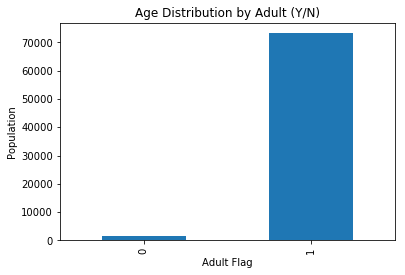

In [10]:
age_distr1 = df.groupby(['Adult']).device_id.nunique()
age_distr2 = df.groupby(['Middle_Age']).device_id.nunique()
age_distr3 = df.groupby(['AgeGroup']).device_id.nunique()
ax1 = age_distr1.plot(kind = 'bar', title = 'Age Distribution by Adult (Y/N)')
# set labels for both axes
ax1.set(xlabel='Adult Flag', ylabel='Population')
plt.show()

In [11]:
df.Adult.value_counts()/df.Adult.count()

1    0.980374
0    0.019626
Name: Adult, dtype: float64

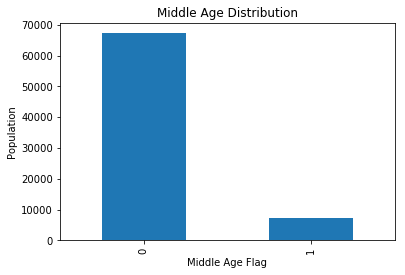

In [12]:
ax2 = age_distr2.plot(kind = 'bar', title = 'Middle Age Distribution')
ax2.set(xlabel='Middle Age Flag', ylabel='Population')
plt.show()

In [13]:
df.Middle_Age.value_counts()/df.Adult.count()

0    0.901093
1    0.098907
Name: Middle_Age, dtype: float64

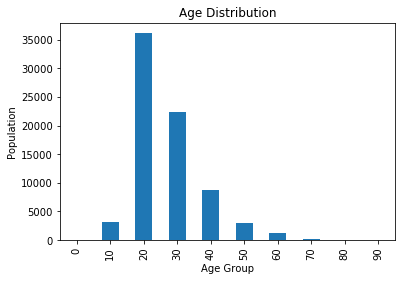

In [14]:
ax3 = age_distr3.plot(kind = 'bar', title = 'Age Distribution')
ax3.set(xlabel='Age Group', ylabel='Population')
plt.show()

In [15]:
df.AgeGroup.value_counts()/df.AgeGroup.count()

20    0.484460
30    0.298408
40    0.116791
10    0.041154
50    0.038783
60    0.016250
70    0.003282
80    0.000764
0     0.000067
90    0.000040
Name: AgeGroup, dtype: float64

### Age vs. Phone Brand
* One brand stands out between "above 30" & "below 30" groups - Meizu!
* Younger generations tend to use Meizu brand which is a cheaper version of IPhone or Samsung

In [16]:
# Phone Brand Model Distribution
df.Brand_Model.value_counts()
counts = df.Brand_Model.value_counts()
percent = df.Brand_Model.value_counts(normalize=True) \
           .mul(100).round(1).astype(str) + '%'
cum_pnct = (counts.cumsum()/counts.sum())\
           .mul(100).round(1).astype(str) + '%'
BrandModel = pd.DataFrame({'counts': counts, 'per': percent, 'cum_pnt':cum_pnct })
BrandModel.head(50)

,counts,cum_pnt,per
"小米,红米note",3013,4.0%,4.0%
"小米,MI 3",2299,7.1%,3.1%
"小米,MI 2S",2136,10.0%,2.9%
"三星,Galaxy Note 3",2065,12.7%,2.8%
"小米,MI 4",1910,15.3%,2.6%
"三星,Galaxy Note 2",1610,17.5%,2.2%
"三星,Galaxy S4",1568,19.6%,2.1%
"华为,荣耀6",1239,21.2%,1.7%
"华为,荣耀畅玩4X",1102,22.7%,1.5%
"华为,荣耀3C",1067,24.1%,1.4%


In [17]:
# Phone Brand Distribution
df.phone_brand.value_counts()
counts = df.phone_brand.value_counts()
percent = df.phone_brand.value_counts(normalize=True) \
           .mul(100).round(1).astype(str) + '%'
cum_pnct = (counts.cumsum()/counts.sum())\
           .mul(100).round(1).astype(str) + '%'
Brand = pd.DataFrame({'counts': counts, 'per': percent, 'cum_pnt':cum_pnct })
Brand_top20 = Brand.head(20)
Brand_top20

,counts,cum_pnt,per
小米,17300,23.2%,23.2%
三星,13669,41.5%,18.3%
华为,12960,58.8%,17.4%
OPPO,5783,66.6%,7.7%
vivo,5637,74.1%,7.6%
魅族,4699,80.4%,6.3%
酷派,3339,84.9%,4.5%
联想,2691,88.5%,3.6%
金立,1123,90.0%,1.5%
HTC,1013,91.4%,1.4%


In [18]:
# Get subset of data where users using top 20 phone brand
# valuelist =Brand_top20.iloc[:,0]
valuelist = Brand_top20.index.values.tolist()
df_subset = df[df.phone_brand.isin(valuelist)]
#a = df_subset.unstack('phone_brand')
#a

In [19]:
# Assign number to top 20 phone brand;
brandencoder = LabelEncoder().fit(df_subset.phone_brand)
df_subset['brand_encode'] = brandencoder.transform(df_subset['phone_brand'])

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [20]:
# Just traslate for top 20 phone brand
def f(row):
    if row['phone_brand'] == '小米':
        val = 'Xiaomi'
    elif row['phone_brand'] == '三星':
        val = 'Samsung'
    elif row['phone_brand'] == '华为':
        val = 'Huawei'
    elif row['phone_brand'] == '魅族':
        val = 'Meizu'
    elif row['phone_brand'] == '酷派':
        val = 'Kupai'
    elif row['phone_brand'] == '联想':
        val = 'Lenovo'
    elif row['phone_brand'] == '金立':
        val = 'Jinli'
    elif row['phone_brand'] == '中兴':
        val = 'Zhongxing'
    elif row['phone_brand'] == '乐视':
        val = 'Yueshi'
    elif row['phone_brand'] == '索尼':
        val = 'Sony'
    elif row['phone_brand'] == '中国移动':
        val = 'ChinaMobile'
    elif row['phone_brand'] == '努比亚':
        val = 'Nubiya'
    elif row['phone_brand'] == '朵唯':
        val = 'Duowei'
    elif row['phone_brand'] == '海信':
        val = 'Haixin'
    elif row['phone_brand'] == '优米':
        val = 'Youmi'
    else:
        val = row['phone_brand']
    return val

In [21]:
df_subset['brand_translate'] = df_subset.apply(f, axis=1)

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
brand_by_agegroup = df_subset.groupby(['AgeGroup', 'brand_translate']).device_id.nunique()#.unstack(1)
brand_by_agegroup_df = pd.DataFrame(brand_by_agegroup).reset_index()#.fillna(method='ffill')

In [23]:
Get_Pnt_Brand = brand_by_agegroup_df.groupby(['AgeGroup','brand_translate'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
Get_Pnt_Brand_pd = pd.DataFrame(Get_Pnt_Brand).reset_index().sort(['AgeGroup','device_id'], ascending = [True, False])
Get_Pnt_Brand_pd.groupby('AgeGroup').head(10).reset_index

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


<bound method DataFrame.reset_index of      AgeGroup brand_translate  device_id
0           0           Meizu   0.800000
1           0         Samsung   0.200000
16         10          Xiaomi   0.246195
6          10          Huawei   0.131214
12         10            OPPO   0.127156
20         10            vivo   0.122421
13         10         Samsung   0.097396
10         10           Meizu   0.096720
8          10           Kupai   0.057491
9          10          Lenovo   0.040243
7          10           Jinli   0.021982
19         10       Zhongxing   0.013527
36         20          Xiaomi   0.250235
33         20         Samsung   0.164566
25         20          Huawei   0.153754
40         20            vivo   0.095029
32         20            OPPO   0.091103
30         20           Meizu   0.084246
27         20           Kupai   0.041938
29         20          Lenovo   0.033431
26         20           Jinli   0.015080
23         20             HTC   0.014368
56         30     

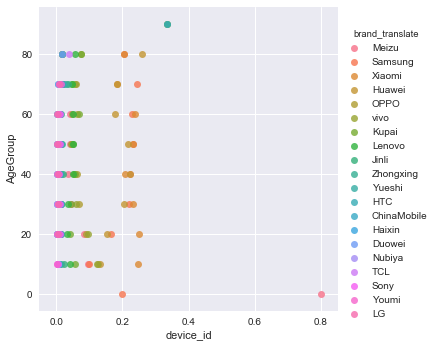

In [24]:
# on aggregated data
import seaborn as sns
sns.lmplot('device_id', 'AgeGroup', data=Get_Pnt_Brand_pd, hue='brand_translate', fit_reg=False)
plt.show()

In [25]:
brand_by_agegroup2 = df_subset.groupby(['Middle_Age', 'brand_translate']).device_id.nunique()
brand_by_agegroup_df2 = pd.DataFrame(brand_by_agegroup2).reset_index()
Get_Pnt_Brand2 = brand_by_agegroup_df2.groupby(['Middle_Age','brand_translate'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
Get_Pnt_Brand_pd2 = pd.DataFrame(Get_Pnt_Brand2).reset_index().sort(['Middle_Age','device_id'], ascending = [True, False])
Get_Pnt_Brand_pd2.groupby('Middle_Age').head(10).reset_index

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of     Middle_Age brand_translate  device_id
15           0          Xiaomi   0.240851
12           0         Samsung   0.183953
4            0          Huawei   0.174950
11           0            OPPO   0.082361
19           0            vivo   0.081090
9            0           Meizu   0.067432
6            0           Kupai   0.045016
8            0          Lenovo   0.035844
5            0           Jinli   0.015449
2            0             HTC   0.014117
32           1         Samsung   0.231274
35           1          Xiaomi   0.219396
24           1          Huawei   0.214366
31           1            OPPO   0.056456
26           1           Kupai   0.055757
28           1          Lenovo   0.048910
39           1            vivo   0.047652
29           1           Meizu   0.041224
38           1       Zhongxing   0.016490
25           1           Jinli   0.015931>

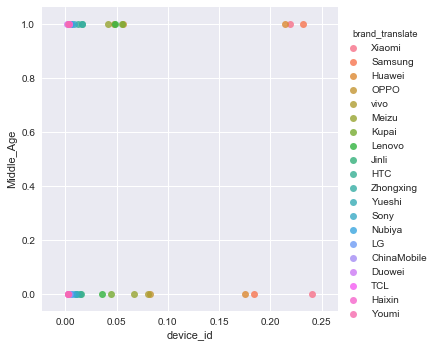

In [26]:
# on aggregated data
sns.lmplot('device_id', 'Middle_Age', data=Get_Pnt_Brand_pd2, hue='brand_translate', fit_reg=False)
plt.show()

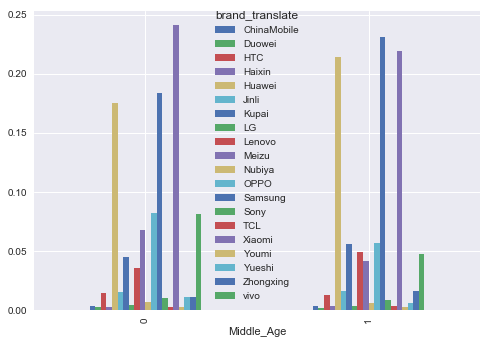

In [27]:
import matplotlib.cm as cm
c = pd.DataFrame(data=Get_Pnt_Brand_pd2).reset_index()
c = c[['Middle_Age','brand_translate', 'device_id']]
ag2 = c.groupby(['Middle_Age','brand_translate']).sum().unstack()
ag2.columns = ag2.columns.droplevel()
ag2.plot(kind = 'bar')
plt.show()

In [28]:
brand_by_agegroup3 = df_subset.groupby(['Adult', 'brand_translate']).device_id.nunique()
brand_by_agegroup_df3 = pd.DataFrame(brand_by_agegroup3).reset_index()
Get_Pnt_Brand3 = brand_by_agegroup_df3.groupby(['Adult','brand_translate'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
Get_Pnt_Brand_pd3 = pd.DataFrame(Get_Pnt_Brand3).reset_index().sort(['Adult','device_id'], ascending = [True, False])
Get_Pnt_Brand_pd3.groupby('Adult').head(10).reset_index

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of     Adult brand_translate  device_id
14      0          Xiaomi   0.251608
18      0            vivo   0.120086
4       0          Huawei   0.113653
10      0            OPPO   0.112938
11      0         Samsung   0.107934
8       0           Meizu   0.085061
6       0           Kupai   0.075768
7       0          Lenovo   0.042888
5       0           Jinli   0.027877
17      0       Zhongxing   0.012866
34      1          Xiaomi   0.238479
31      1         Samsung   0.190215
23      1          Huawei   0.180126
30      1            OPPO   0.079151
38      1            vivo   0.076956
28      1           Meizu   0.064446
25      1           Kupai   0.045492
27      1          Lenovo   0.037021
24      1           Jinli   0.015253
21      1             HTC   0.014043>

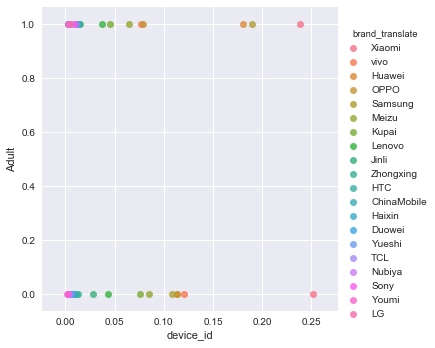

In [29]:
# on aggregated data
sns.lmplot('device_id', 'Adult', data=Get_Pnt_Brand_pd3, hue='brand_translate', fit_reg=False)
plt.show()

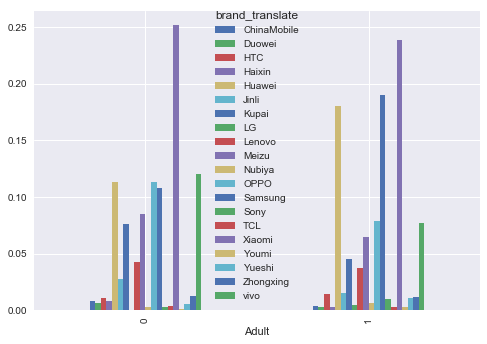

In [30]:
d = pd.DataFrame(data=Get_Pnt_Brand_pd3).reset_index()
d = d[['Adult','brand_translate', 'device_id']]
ag3 = d.groupby(['Adult','brand_translate']).sum().unstack()
ag3.columns = ag3.columns.droplevel()
ag3.plot(kind = 'bar')
plt.show()

In [31]:
brandmodel_by_agegroup = df_subset.groupby(['Adult', 'Brand_Model']).device_id.nunique()
brandmodel_by_agegroup_df = pd.DataFrame(brandmodel_by_agegroup).reset_index()
Get_Pnt_BrandModel =brandmodel_by_agegroup_df.groupby(['Adult','Brand_Model'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
Get_Pnt_BrandModel_df = pd.DataFrame(Get_Pnt_BrandModel).reset_index().sort(['Adult','device_id'], ascending = [True, False])
Get_Pnt_BrandModel_df.groupby('Adult').head(10).reset_index

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of       Adult       Brand_Model  device_id
232       0         小米,红米note   0.052180
221       0           小米,MI 4   0.025733
220       0           小米,MI 3   0.024303
233       0      小米,红米note增强版   0.024303
228       0           小米,红米2A   0.023588
354       0       魅族,魅蓝Note 2   0.022873
353       0         魅族,魅蓝NOTE   0.022159
230       0        小米,红米Note2   0.017870
219       0          小米,MI 2S   0.016440
227       0            小米,红米2   0.015011
1031      1         小米,红米note   0.041369
1013      1           小米,MI 3   0.031871
1012      1          小米,MI 2S   0.029733
664       1  三星,Galaxy Note 3   0.028902
1014      1           小米,MI 4   0.026369
663       1  三星,Galaxy Note 2   0.022458
687       1      三星,Galaxy S4   0.021979
988       1            华为,荣耀6   0.017265
1000      1         华为,荣耀畅玩4X   0.015295
983       1           华为,荣耀3C   0.014761>

### Age vs. App Category
* It appears that app categories such as "wealth management" & "P2P net loan" are tend to be used by above 30 groups
* App categories such as "onlinemalls" & "Liquid medium" are tend to be use by younger crowd (below 30)

In [32]:
device_list = df['device_id'].tolist()
df_eventsubset = event[event.device_id.isin(device_list)]
df_events = df_eventsubset.merge(app_event, on = ['event_id'])

In [33]:
df_events = df_events[df_events.is_active == 1]

In [34]:
# Frequency of Active Use by App Category
# To be Fixed 
'''df_events.groupby(['device_id', 'app_id']).apply(lambda x: pd.Series(dict(
    sum_active=(x.is_active == 1).sum(),
    sum_all=((x.is_active == 1)|(x.is_active == 0)).sum()
    active_pnt =(x.is_active == 1).sum() / ((x.is_active == 1)|(x.is_active == 0)).sum()
)))'''

"df_events.groupby(['device_id', 'app_id']).apply(lambda x: pd.Series(dict(\n    sum_active=(x.is_active == 1).sum(),\n    sum_all=((x.is_active == 1)|(x.is_active == 0)).sum()\n    active_pnt =(x.is_active == 1).sum() / ((x.is_active == 1)|(x.is_active == 0)).sum()\n)))"

In [35]:
df_events_new = df_events.loc[:,('device_id', 'app_id')].drop_duplicates()
app_label = app_label.drop_duplicates()
label_cat = label_cat.drop_duplicates()

In [36]:
device_app = df_events_new.merge(app_label, on = ['app_id']).merge(label_cat, on = ['label_id'])
df2 = df.merge(device_app, on = ['device_id'])
len(df2)

1997581

In [37]:
df3 = df2[(df2.category != 'Industry tag') & (df2.category != 'Property Industry 1.0') & (df2.category != 'Property Industry 2.0')
         & (df2.category != 'unknown') & (df2.category != 'Relatives 1') & (df2.category != 'Services 1') & (df2.category != '1 free')
         & (df2.category != 'Custom label') & (df2.category != 'And the Church') & (df2.category != 'IM')]
a = df3.groupby(['Adult', 'category']).device_id.nunique()
top5_app = a.groupby(level=0).nlargest(5)
top5_app

Adult  Adult  category                
0      0      video                         156
              Personal Effectiveness 1      128
              music                         121
              Cozy 1                        119
              Finance                       118
1      1      Internet banking            15282
              Finance                     14761
              Personal Effectiveness 1    12810
              Low risk                    12337
              Pay                         11928
Name: device_id, dtype: int64

In [38]:
app_category = df3.groupby(['Middle_Age', 'category']).device_id.nunique()
app_category_df = pd.DataFrame(app_category).reset_index()
app_category_pnt = app_category_df.groupby(['Middle_Age','category'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
app_category_pnt_df = pd.DataFrame(app_category_pnt).reset_index().sort(['Middle_Age','device_id'], ascending = [True, False])
app_category_pnt_df.groupby('Middle_Age').head(30).reset_index


C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of      Middle_Age                  category  device_id
123           0          Internet banking   0.028040
86            0                   Finance   0.027357
173           0  Personal Effectiveness 1   0.023561
140           0                  Low risk   0.022917
170           0                       Pay   0.022026
150           0    Moderate profitability   0.021302
100           0                 High Flow   0.021258
229           0       Third party payment   0.021153
404           0                     video   0.020800
250           0         Wealth Management   0.019905
359           0              online malls   0.019845
165           0              P2P net loan   0.019626
131           0             Liquid medium   0.019300
65            0          Debit and credit   0.018708
164           0                       P2P   0.018246
103           0                 High risk   0.018087
287           0                   fashion   0.016920
105    

In [39]:
app_category2 = df3.groupby(['Adult', 'category']).device_id.nunique()
app_category_df2 = pd.DataFrame(app_category2).reset_index()
app_category_pnt2 = app_category_df2.groupby(['Adult','category'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
app_category_pnt_df2 = pd.DataFrame(app_category_pnt2).reset_index().sort(['Adult','device_id'], ascending = [True, False])
app_category_pnt_df2.groupby('Adult').head(30).reset_index

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of      Adult                  category  device_id
263      0                     video   0.039806
109      0  Personal Effectiveness 1   0.032661
224      0                     music   0.030875
34       0                    Cozy 1   0.030365
50       0                   Finance   0.030110
230      0              online malls   0.024751
76       0          Internet banking   0.023731
107      0                       Pay   0.023220
179      0                   fashion   0.021944
85       0                  Low risk   0.021179
170      0                 community   0.020669
236      0      pictures photography   0.020413
57       0                 High Flow   0.019648
91       0    Moderate profitability   0.019648
142      0       Third party payment   0.019648
140      0                   Tencent   0.017607
243      0                     radio   0.015820
37       0              Customized 1   0.014800
157      0         Wealth Management   0.014034
2

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


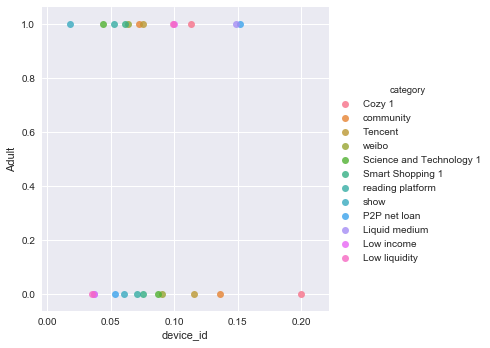

In [40]:
app_category_feature =df3[(df3.category == 'Tencent')|(df3.category == 'Smart Shopping 1')
                         |(df3.category == 'show')|(df3.category == 'Science and Technology 1')|(df3.category == 'reading platform')
                         |(df3.category == 'P2P net loan')|(df3.category == 'Low liquidity')|(df3.category == 'Low income')
                         |(df3.category == 'Liquid medium')|(df3.category == 'weibo')|(df3.category == 'community')
                         |(df3.category == 'Cozy 1')].groupby(['Adult', 'category']).device_id.nunique()
app_category_feature = pd.DataFrame(app_category_feature).reset_index()
app_category_feature = app_category_feature.groupby(['Adult','category'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
app_category_feature = pd.DataFrame(app_category_feature).reset_index().sort(['Adult','device_id'], ascending = [True, False])

sns.lmplot('device_id', 'Adult', data=app_category_feature , hue='category', fit_reg=False)
plt.show()

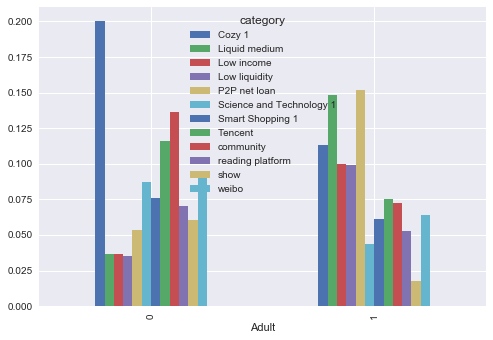

In [41]:
import matplotlib.cm as cm
b = pd.DataFrame(app_category_feature).reset_index()
b = b[['Adult','category', 'device_id']]
ag1 = b.groupby(['Adult','category']).sum().unstack()
ag1.columns = ag1.columns.droplevel()
ag1.plot(kind = 'bar')
plt.show()

### Age vs. Activity Time During the Day


In [42]:
event_new = event.merge(gatrain, on = ['device_id'])

In [43]:
# re-format timestamp column to datetime format in order to get other time attributes later
event_new.timestamp = event_new.timestamp.apply(pd.to_datetime)
event_new['hour'] = event_new['timestamp'].dt.hour
event_new['day'] = event_new['timestamp'].dt.day
event_new['dayofweek'] = event_new['timestamp'].dt.dayofweek+1
event_new['Adult'] = np.where(event_new.age<=18,0,1)
event_new['Middle_Age'] = np.where((event_new.age<=65) & (df.age>=45),1,0)
event_new['AgeGroup'] = event_new.age//10*10
event_new

,event_id,device_id,timestamp,longitude,latitude,gender,age,group,hour,day,dayofweek,Adult,Middle_Age,AgeGroup
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,M,46,M39+,0,1,7,1,0,40
1,7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,M,46,M39+,9,2,1,1,0,40
2,29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,M,46,M39+,0,4,3,1,0,40
3,33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,M,46,M39+,5,6,5,1,0,40
4,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,M,46,M39+,9,6,5,1,0,40
5,66398,29182687948017175,2016-05-01 01:56:06,121.38,31.24,M,46,M39+,1,1,7,1,0,40
6,70894,29182687948017175,2016-05-06 01:14:46,121.38,31.24,M,46,M39+,1,6,5,1,0,40
7,87185,29182687948017175,2016-05-01 09:20:01,121.38,31.24,M,46,M39+,9,1,7,1,0,40
8,94644,29182687948017175,2016-05-07 07:16:35,121.38,31.24,M,46,M39+,7,7,6,1,0,40
9,110018,29182687948017175,2016-05-06 21:00:40,121.38,31.24,M,46,M39+,21,6,5,1,0,40


In [44]:
# group by age and hour
en = event_new.groupby(['AgeGroup', 'hour']).device_id.nunique()
#top_hours = en.groupby(level=0).nlargest(5)
en  = pd.DataFrame(en ).reset_index()
en  = en.groupby(['AgeGroup','hour'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
en  = pd.DataFrame(en).reset_index().sort(['AgeGroup','device_id'], ascending = [True, False])
en.groupby('AgeGroup').head(30).reset_index


C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of      AgeGroup  hour  device_id
18         10    18   0.055642
12         10    12   0.055420
22         10    22   0.054090
21         10    21   0.052982
13         10    13   0.052760
20         10    20   0.052760
11         10    11   0.052317
23         10    23   0.052317
19         10    19   0.051652
10         10    10   0.049656
9          10     9   0.049213
15         10    15   0.046553
14         10    14   0.046331
17         10    17   0.046331
16         10    16   0.044114
0          10     0   0.040346
8          10     8   0.039902
7          10     7   0.039459
1          10     1   0.027488
6          10     6   0.025493
2          10     2   0.020173
5          10     5   0.016183
3          10     3   0.015518
4          10     4   0.013301
34         20    10   0.051681
36         20    12   0.051394
35         20    11   0.051214
45         20    21   0.050819
44         20    20   0.050232
46         20    22   0.050028


In [45]:
en2 = event_new.groupby(['Adult', 'hour']).device_id.nunique()
#top_hours = en.groupby(level=0).nlargest(20)
en2  = pd.DataFrame(en2).reset_index()
en2  = en2.groupby(['Adult','hour'])['device_id'].sum().groupby(level = 0).transform(lambda x: x/x.sum())
en2  = pd.DataFrame(en2).reset_index().sort(['Adult','device_id'], ascending = [True, False])
en2.groupby('Adult').head(24).reset_index

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<bound method DataFrame.reset_index of     Adult  hour  device_id
18      0    18   0.058155
21      0    21   0.056818
12      0    12   0.056150
13      0    13   0.055481
22      0    22   0.055481
19      0    19   0.052807
23      0    23   0.052139
10      0    10   0.050802
20      0    20   0.050134
11      0    11   0.049465
9       0     9   0.046123
16      0    16   0.046123
17      0    17   0.046123
14      0    14   0.044118
15      0    15   0.043449
0       0     0   0.038770
7       0     7   0.037433
8       0     8   0.036096
6       0     6   0.030080
1       0     1   0.026738
2       0     2   0.019385
5       0     5   0.018717
3       0     3   0.015374
4       0     4   0.014037
34      1    10   0.051776
45      1    21   0.051426
35      1    11   0.050747
36      1    12   0.050613
44      1    20   0.050469
33      1     9   0.049713
43      1    19   0.049702
46      1    22   0.048750
42      1    18   0.048549
37      1    13   0.048539
41      1    17 

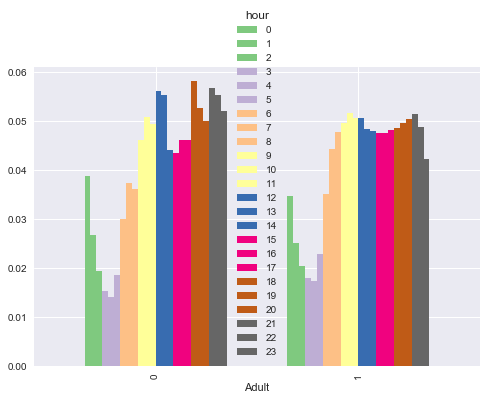

In [46]:
import matplotlib.cm as cm
a = pd.DataFrame(en2).reset_index()
a = a[['Adult','hour', 'device_id']]
ag = a.groupby(['Adult','hour']).sum().unstack()
ag.columns = ag.columns.droplevel()
ag.plot(kind = 'bar', colormap = cm.Accent, width = 0.7)
plt.show()

### Logistic Regression Predict Age-30-Split Based on Phone Brand and App Category

* First, downsize Adult Sample Size & upsize Non-Adult group
* Logistic Regression
* Cross Validation
* ROC curve and check AUC

In [47]:
df_model_base_data = df2
df2.Adult.value_counts()

1    1984089
0      13492
Name: Adult, dtype: int64

In [49]:
# Duplicate non-adult group dataframe
non_adult = np.array(df2[df2.Adult == 0])
non_adult_newsample = pd.DataFrame(pd.np.tile(non_adult, (150, 1)))

In [50]:
# Consolidate non adult new sample and adult sample to new training sample
adult = df2[df2.Adult ==1]
all_dfs = [adult, non_adult_newsample]
# Give all df's common column names
for df_new in all_dfs:
    df_new.columns = ['device_id', 'gender', 'age', 'group', 'phone_brand', 'device_model', 'Brand_Model', 'Adult', 
                     'Middle_Age', 'AgeGroup', 'app_id', 'label_id', 'category']

df_model_base_data = pd.concat(all_dfs).reset_index(drop=True)

In [52]:
# Create dummy variables for each feature
df_model_base_data['Samsung_Brand'] = np.where(df_model_base_data.phone_brand=='三星',1, 0)
df_model_base_data['Kupai_Brand'] = np.where(df_model_base_data.phone_brand=='酷派',1, 0)
df_model_base_data['Liquid_medium'] = np.where(df_model_base_data.category =='Liquid medium',1, 0)
df_model_base_data['Low_income'] = np.where(df_model_base_data.category =='Low income',1, 0)
df_model_base_data['Low_liquidity'] = np.where(df_model_base_data.category =='Low liquidity',1, 0)
df_model_base_data['P2P_net_loan'] = np.where(df_model_base_data.category =='P2P net loan',1, 0)
df_model_base_data['show'] = np.where(df_model_base_data.category =='show',1, 0)
df_model_base_data['Science_Technology'] = np.where(df_model_base_data.category =='Science and Technology 1',1, 0)
df_model_base_data['Adult_Flag'] = np.where(df_model_base_data.age >=18 ,1, 0)

In [53]:
df_model_base_data.head()

,device_id,gender,age,group,phone_brand,device_model,Brand_Model,Adult,Middle_Age,AgeGroup,...,category,Samsung_Brand,Kupai_Brand,Liquid_medium,Low_income,Low_liquidity,P2P_net_loan,show,Science_Technology,Adult_Flag
0,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30,...,Property Industry 1.0,0,0,0,0,0,0,0,0,1
1,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30,...,Property Industry 1.0,0,0,0,0,0,0,0,0,1
2,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30,...,Property Industry 1.0,0,0,0,0,0,0,0,0,1
3,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30,...,Personal Effectiveness 1,0,0,0,0,0,0,0,0,1
4,-8260683887967679142,M,35,M32-38,小米,MI 2,"小米,MI 2",1,0,30,...,Property Industry 2.0,0,0,0,0,0,0,0,0,1


In [54]:
# Keep all useful columns
df_model_base_data_New = df_model_base_data[['Adult_Flag', 'Samsung_Brand', 'Kupai_Brand', 'Liquid_medium', 'Low_income', 'Low_liquidity', 
                                            'P2P_net_loan', 'show', 'Science_Technology']]
# manually add the intercept
df_model_base_data_New['intercept'] = 1

C:\Users\Felix\Python\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
df_model_base_data_New.head()

,Adult_Flag,Samsung_Brand,Kupai_Brand,Liquid_medium,Low_income,Low_liquidity,P2P_net_loan,show,Science_Technology,intercept
0,1,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,1


In [75]:
train_cols = df_model_base_data_New.iloc[:,1:7]

In [76]:
train_cols.head()

,Samsung_Brand,Kupai_Brand,Liquid_medium,Low_income,Low_liquidity,P2P_net_loan
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [77]:
train_cols.Liquid_medium.value_counts()

0    3972660
1      35229
Name: Liquid_medium, dtype: int64

In [78]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    train_cols, df_model_base_data_New.Adult_Flag, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(3005916, 6)
(1001973, 6)
(3005916,)
(1001973,)


In [79]:
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

In [80]:
df_model_base_data_New.dtypes

Adult_Flag            int32
Samsung_Brand         int32
Kupai_Brand           int32
Liquid_medium         int32
Low_income            int32
Low_liquidity         int32
P2P_net_loan          int32
show                  int32
Science_Technology    int32
intercept             int64
dtype: object

In [81]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, Y_train)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_test), Y_test))

C:\Users\Felix\Python\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.753900554207


### Tuning the Model

In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [65]:
clf = LogisticRegression()
X_train_array = DataFrame.as_matrix(X_train)
Y_train_array = DataFrame.as_matrix(Y_train)
score = cv_score(clf, X_train_array, Y_train_array)
print(score)

C:\Users\Felix\Python\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.753904300829


In [88]:
clf.coef_

array([[ 1.33043694, -0.55804738,  1.27068568,  0.85414957,  0.95888461,
         1.28935062]])

In [66]:
#Find the best C
#the grid of parameters to search over
Cs = [0.001,0.05,0.01, 0.1,1, 10, 100]

max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, X_train_array, Y_train_array)

        if score > max_score:
            max_score = score
            best_C =C
print (max_score, best_C)

C:\Users\Felix\Python\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.753904300829 0.05


### AUC ROC Evaluation

In [82]:
from sklearn.metrics import roc_curve, auc

In [89]:
Predictions= clf.predict(X_test)
Actual= np.array(Y_test)

In [90]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Actual, Predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

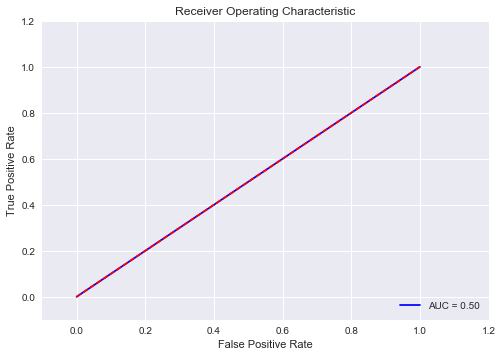

In [91]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [92]:
clf.coef_

array([[ 1.33043694, -0.55804738,  1.27068568,  0.85414957,  0.95888461,
         1.28935062]])